# Minimal Q-Learning in a 5×5 GridWorld (4 actions)



In [81]:
# Import Required Libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# Constants and Hyperparameters
N_ROWS, N_COLS = 25, 25
START = (0, 0)
GOAL = (24, 24)
WALLS = [
    (2, 2), (3, 4), (5, 1), (7, 3), (4, 6), (8, 2), (6, 7),
    (2, 15), (4, 18), (6, 12), (8, 20), (3, 22), (7, 16), (9, 14),
    (15, 2), (18, 5), (20, 1), (16, 7), (22, 4), (19, 8), (17, 3),
    (15, 18), (17, 21), (19, 16), (21, 19), (18, 23), (16, 15), (20, 17),
    (10, 10), (12, 8), (14, 12), (11, 15), (13, 6), (9, 18), (15, 9),
    (5, 11), (8, 16), (11, 3), (14, 20), (17, 6), (20, 13), (23, 8),
    (1, 9), (4, 14), (7, 19), (10, 22), (13, 17), (16, 11), (19, 2),
    (22, 15), (6, 5), (9, 8), (12, 18), (15, 4), (18, 14), (21, 7),
    (1, 23), (23, 1), (3, 0), (0, 3), (24, 21), (21, 24)
]
STEP_REWARD = -0.1
BUMP_REWARD = -0.1
GOAL_REWARD = 1.0
GAMMA = 0.95
ALPHA = 0.5
EPISODES = 600
EPS_START, EPS_END, EPS_DECAY_EPISODES = 1.0, 0.05, 300
MAX_STEPS = 200
SEED = 123

In [82]:
class GridWorld:
    def __init__(self, n_rows, n_cols, start, goal, walls, step_reward, goal_reward, gamma):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.start = start
        self.goal = goal
        self.walls = set(walls)
        self.step_reward = step_reward
        self.goal_reward = goal_reward
        self.gamma = gamma

    def in_bounds(self, state):
        r, c = state
        return 0 <= r < self.n_rows and 0 <= c < self.n_cols

    def step(self, state, action, actions):
        if state == self.goal:
            return state, 0.0, True
        dr, dc = actions[action]
        next_state = (state[0] + dr, state[1] + dc)
        if not self.in_bounds(next_state) or next_state in self.walls:
            next_state = state  # Stay put if invalid
        reward = self.goal_reward if next_state == self.goal else self.step_reward
        done = next_state == self.goal
        return next_state, reward, done

    def to_index(self, state):
        r, c = state
        return r * self.n_cols + c

    def from_index(self, index):
        r = index // self.n_cols
        c = index % self.n_cols
        return (r, c)

# Initialize the GridWorld environment
grid_world = GridWorld(
    n_rows=25,
    n_cols=25,
    start=(0, 0),
    goal=(24, 24),
    walls = WALLS,
    step_reward=-0.1,
    goal_reward=1.0,
    gamma=0.95
)

All required functions:

In [83]:
# Removed utility functions as they are now part of the GridWorld class.
# Use grid_world.to_index, grid_world.from_index, and grid_world.step instead.

In [84]:
# Action definitions
ACTIONS_4 = {
    0: (-1, 0),  # Up
    1: ( 1, 0),  # Down
    2: ( 0,-1),  # Left
    3: ( 0, 1),  # Right
}

ACTIONS_5 = dict(ACTIONS_4)
ACTIONS_5[4] = (1, 1)  # south-east (down-right)

# Utility functions
def epsilon_greedy(q_row, epsilon, rng):
    """Epsilon-greedy action selection"""
    if rng.random() < epsilon:
        return int(rng.integers(len(q_row)))
    # break ties randomly among maxima
    max_q = np.max(q_row)
    best = np.flatnonzero(q_row == max_q)
    return int(rng.choice(best))

def moving_average(x, w=20):
    """Calculate moving average"""
    if len(x) < w:
        return x.copy()
    return np.convolve(x, np.ones(w)/w, mode='valid')

# Legacy function wrappers for compatibility
def to_index(s):
    return grid_world.to_index(s)

def from_index(i):
    return grid_world.from_index(i)

def step(s, a, actions):
    return grid_world.step(s, a, actions)

More functions for visualisation:

In [85]:
class Visualizer:
    ARROWS = {0: '↑', 1: '↓', 2: '←', 3: '→', 4: '↘'}

    @staticmethod
    def derive_policy(Q, n_rows, n_cols):
        return np.argmax(Q, axis=1).reshape(n_rows, n_cols)

    @staticmethod
    def render_policy(policy, n_rows, n_cols, walls, start, goal):
        grid = []
        for r in range(n_rows):
            row = []
            for c in range(n_cols):
                s = (r, c)
                if s in walls:
                    row.append('■')
                elif s == goal:
                    row.append('G')
                elif s == start:
                    row.append('S')
                else:
                    row.append(Visualizer.ARROWS[int(policy[r, c])])
            grid.append(' '.join(row))
        print('\nOptimal policy (arrows), S=start, G=goal, ■=wall')
        print('\n'.join(grid))

    @staticmethod
    def print_value_grid(Q, n_rows, n_cols):
        V = np.max(Q, axis=1).reshape(n_rows, n_cols)
        with np.printoptions(precision=2, suppress=True):
            print('\nState-value grid V(s)=max_a Q(s,a):')
            print(V)

    @staticmethod
    def plot_results(returns, bumps, ma_window, label_prefix):
        ret_ma = np.convolve(returns, np.ones(ma_window)/ma_window, mode='valid')
        bumps_ma = np.convolve(bumps, np.ones(ma_window)/ma_window, mode='valid')

        plt.figure(figsize=(7.5, 4.2))
        plt.plot(np.arange(len(returns))[-len(ret_ma):], ret_ma, label=f'Return: {label_prefix}')
        plt.xlabel('Episode')
        plt.ylabel('Discounted return')
        plt.title('Q-learning in GridWorld')
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(7.5, 4.2))
        plt.plot(bumps_ma, label=f'Total bumps: {label_prefix}')
        plt.xlabel('Episode')
        plt.ylabel('Total Bumps')
        plt.title('Q-learning in GridWorld')
        plt.legend()
        plt.tight_layout()
        plt.show()

## **1. Q learning with 4 actions:**

In [86]:
# Q-learning with 4 actions using refactored approach
rng = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)

NUM_STATES = N_ROWS * N_COLS
NUM_ACTIONS_4 = 4
Q4 = np.zeros((NUM_STATES, NUM_ACTIONS_4), dtype=float)

returns = np.zeros(EPISODES, dtype=float)
bumps = np.zeros(EPISODES, dtype=float)
steps_arr = np.zeros(EPISODES, dtype=int)

eps = EPS_START
eps_decay = (EPS_START - EPS_END) / max(1, EPS_DECAY_EPISODES)

for ep in range(EPISODES):
    s = START
    si = grid_world.to_index(s)
    done = False
    G = 0.0
    bumpcount = 0
    disc = 1.0
    steps = 0

    for t in range(MAX_STEPS):
        a = epsilon_greedy(Q4[si], eps, rng)
        s_next, r, done = grid_world.step(s, a, ACTIONS_4)
        s_next_i = grid_world.to_index(s_next)

        if si == s_next_i:
            bumpcount += 1
            r = BUMP_REWARD

        target = r if done else r + GAMMA * np.max(Q4[s_next_i])
        Q4[si, a] += ALPHA * (target - Q4[si, a])

        G += r
        disc *= GAMMA
        s, si = s_next, s_next_i
        steps += 1
        if done:
            break

    returns[ep] = G
    bumps[ep] = bumpcount
    steps_arr[ep] = steps
    if ep < EPS_DECAY_EPISODES:
        eps = max(EPS_END, eps - eps_decay)

print('Training (4 actions) complete!')
returns4 = returns.copy()
bumps4 = bumps.copy()
ma_w = 25
ret_ma4 = moving_average(returns4, w=ma_w)

policy4 = Visualizer.derive_policy(Q4, N_ROWS, N_COLS)
Visualizer.render_policy(policy4, N_ROWS, N_COLS, WALLS, START, GOAL)
Visualizer.print_value_grid(Q4, N_ROWS, N_COLS)

Training (4 actions) complete!

Optimal policy (arrows), S=start, G=goal, ■=wall
S ↓ ↓ ■ ↑ → ↓ ↑ → → ↓ → ↑ ↓ → ↑ ← ↓ ↓ ← → → ↓ ↑ →
↑ ↓ → ↓ → → → ↓ ↑ ■ ↓ ↑ ↓ → ↑ ↓ ↓ ↑ ← ↓ → ↓ ↓ ■ ↓
→ → ■ → → → ← ↓ ↓ ↑ → ↑ → → → ■ ← → ↑ → ↓ ← ↑ ↑ →
■ ↑ ← ↑ ■ ← ← → → → → ↓ ↑ → ↑ → → ↓ → ↓ → ↓ ■ ↓ ↑
↑ ← → → ↑ → ■ ↓ → → → ↓ ↓ ← ■ ↓ ↑ → ■ ← → ↓ ← ↑ ↑
↑ ■ ← → ↓ → → ← → ↓ ↓ ■ ↓ → ↑ ← ← → → ↓ → ↓ ↓ ↓ ↓
↓ ↓ ← ↓ → ■ ↑ ■ ↓ ↑ → → ■ → ↓ ↓ ← ← → → → ↓ → ↓ ↓
← ↓ ↓ ■ → ↑ ↑ ↓ ↓ → → ↓ ← ← ← ↑ ■ ↓ ↓ ■ → ↓ ↓ → ↓
↓ ↓ ■ ↑ ↑ ↓ → ↓ ↓ → ↓ ↓ → ↑ ↑ ↓ ■ → → ↓ ■ ↓ ← ↓ ↓
↓ ↓ ← ↑ ↓ ↓ ↓ → ■ ↓ ↓ ↓ ↓ ↓ ■ → ↓ ↓ ■ → → ↓ ← ↓ ↓
→ → ↓ → ↓ → → ↓ → ↓ ■ ← ↑ ↓ ↓ → ↓ → → → → ↓ ■ ↓ ←
→ ↑ ← ■ → → ↓ → ↑ → → ↓ ↓ ↓ ↓ ■ ↓ → → ↓ → ↓ ↓ ← ↓
↓ ↓ ↓ ↓ ← → ↑ ↓ ■ ← ↓ ↓ → ↓ → ↓ ↓ ↑ ■ → → ↓ ↓ ↓ ↓
↓ ↓ ↓ ↓ → ↑ ■ ↓ ← ← → → → → → ↓ ↓ ■ ↓ → → → ↓ ← ←
← ↓ → ↓ ↑ → → ↓ ↓ → ↓ ↓ ■ ↓ ↓ → ↓ ↓ ← ↑ ■ ↓ ↓ ← →
← → ■ ↓ ■ ↓ ↓ → ↓ ■ → → → ↓ → → → ↓ ■ ↓ ↓ ↓ ↓ ← ↓
↓ ← ↑ ↑ ↑ ↑ ↓ ■ → ↓ ↓ ■ ↓ → ↓ ■ ↓ ↓ ↑ ↓ ↓ → ↓ ← ↓
→ ↑ ← ■ ↓ ↓ ■ ↑ → → → → → → → → → ↓ → ↓ ↓ ■ ↓ ← ↓
→ ↑ ← ↑ ↓ ■ ← ← → ↓

## Add a 5th action: South‑East diagonal


In [87]:
# Demo: take one south-east step from (3,2) using the new action map
s_demo = (3, 2)
s_next_demo, r_demo, done_demo = grid_world.step(s_demo, 4, ACTIONS_5)
print('From', s_demo, 'SE ->', s_next_demo, '| reward=', r_demo, '| done=', done_demo)
Visualizer.render_policy(policy4, N_ROWS, N_COLS, WALLS, START, GOAL)

From (3, 2) SE -> (4, 3) | reward= -0.1 | done= False

Optimal policy (arrows), S=start, G=goal, ■=wall
S ↓ ↓ ■ ↑ → ↓ ↑ → → ↓ → ↑ ↓ → ↑ ← ↓ ↓ ← → → ↓ ↑ →
↑ ↓ → ↓ → → → ↓ ↑ ■ ↓ ↑ ↓ → ↑ ↓ ↓ ↑ ← ↓ → ↓ ↓ ■ ↓
→ → ■ → → → ← ↓ ↓ ↑ → ↑ → → → ■ ← → ↑ → ↓ ← ↑ ↑ →
■ ↑ ← ↑ ■ ← ← → → → → ↓ ↑ → ↑ → → ↓ → ↓ → ↓ ■ ↓ ↑
↑ ← → → ↑ → ■ ↓ → → → ↓ ↓ ← ■ ↓ ↑ → ■ ← → ↓ ← ↑ ↑
↑ ■ ← → ↓ → → ← → ↓ ↓ ■ ↓ → ↑ ← ← → → ↓ → ↓ ↓ ↓ ↓
↓ ↓ ← ↓ → ■ ↑ ■ ↓ ↑ → → ■ → ↓ ↓ ← ← → → → ↓ → ↓ ↓
← ↓ ↓ ■ → ↑ ↑ ↓ ↓ → → ↓ ← ← ← ↑ ■ ↓ ↓ ■ → ↓ ↓ → ↓
↓ ↓ ■ ↑ ↑ ↓ → ↓ ↓ → ↓ ↓ → ↑ ↑ ↓ ■ → → ↓ ■ ↓ ← ↓ ↓
↓ ↓ ← ↑ ↓ ↓ ↓ → ■ ↓ ↓ ↓ ↓ ↓ ■ → ↓ ↓ ■ → → ↓ ← ↓ ↓
→ → ↓ → ↓ → → ↓ → ↓ ■ ← ↑ ↓ ↓ → ↓ → → → → ↓ ■ ↓ ←
→ ↑ ← ■ → → ↓ → ↑ → → ↓ ↓ ↓ ↓ ■ ↓ → → ↓ → ↓ ↓ ← ↓
↓ ↓ ↓ ↓ ← → ↑ ↓ ■ ← ↓ ↓ → ↓ → ↓ ↓ ↑ ■ → → ↓ ↓ ↓ ↓
↓ ↓ ↓ ↓ → ↑ ■ ↓ ← ← → → → → → ↓ ↓ ■ ↓ → → → ↓ ← ←
← ↓ → ↓ ↑ → → ↓ ↓ → ↓ ↓ ■ ↓ ↓ → ↓ ↓ ← ↑ ■ ↓ ↓ ← →
← → ■ ↓ ■ ↓ ↓ → ↓ ■ → → → ↓ → → → ↓ ■ ↓ ↓ ↓ ↓ ← ↓
↓ ← ↑ ↑ ↑ ↑ ↓ ■ → ↓ ↓ ■ ↓ → ↓ ■ ↓ ↓ ↑ ↓ ↓ → ↓ ← ↓
→ ↑ ← ■ ↓ ↓ ■ ↑ → → → → → → → → → ↓ → ↓ ↓ ■ ↓ 

## **2. Plain Q learning with 5 actions:**

In [88]:
class QLearningAgent:
    def __init__(self, grid_world, n_actions, episodes=600, alpha=0.5, 
                 eps_start=1.0, eps_end=0.05, eps_decay_episodes=300, 
                 max_steps=200, seed=123):
        self.grid_world = grid_world
        self.n_actions = n_actions
        self.episodes = episodes
        self.alpha = alpha
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay_episodes = eps_decay_episodes
        self.max_steps = max_steps
        self.seed = seed
        
        # Initialize random number generators
        self.rng = np.random.default_rng(seed)
        random.seed(seed)
        np.random.seed(seed)
        
        # Initialize Q-table and tracking arrays
        self.num_states = grid_world.n_rows * grid_world.n_cols
        self.Q = np.zeros((self.num_states, n_actions), dtype=float)
        self.returns = np.zeros(episodes, dtype=float)
        self.bumps = np.zeros(episodes, dtype=float)
        self.steps_arr = np.zeros(episodes, dtype=int)
        
        # Epsilon decay calculation
        self.eps_decay = (eps_start - eps_end) / max(1, eps_decay_episodes)
    
    def train(self, actions_dict, epsilon_greedy_func, bump_reward):
        """Train the Q-learning agent"""
        eps = self.eps_start
        
        for ep in range(self.episodes):
            s = self.grid_world.start
            si = self.grid_world.to_index(s)
            done = False
            G = 0.0
            bumpcount = 0
            disc = 1.0
            steps = 0

            for t in range(self.max_steps):
                a = epsilon_greedy_func(self.Q[si], eps, self.rng)
                s_next, r, done = self.grid_world.step(s, a, actions_dict)
                s_next_i = self.grid_world.to_index(s_next)

                if si == s_next_i:
                    bumpcount += 1
                    r = bump_reward

                target = r if done else r + self.grid_world.gamma * np.max(self.Q[s_next_i])
                self.Q[si, a] += self.alpha * (target - self.Q[si, a])

                G += r
                disc *= self.grid_world.gamma
                s, si = s_next, s_next_i
                steps += 1
                if done:
                    break

            self.returns[ep] = G
            self.bumps[ep] = bumpcount
            self.steps_arr[ep] = steps
            
            if ep < self.eps_decay_episodes:
                eps = max(self.eps_end, eps - self.eps_decay)
        
        print(f'Training ({self.n_actions} actions) complete!')
    
    def get_policy(self, n_rows, n_cols):
        """Get the derived policy from Q-table"""
        return Visualizer.derive_policy(self.Q, n_rows, n_cols)
    
    def get_results(self, moving_average_func, ma_window=25):
        """Get training results with moving averages"""
        return {
            'returns': self.returns.copy(),
            'Q': self.Q.copy(),
            'bumps': self.bumps.copy(),
            'returns_ma': moving_average_func(self.returns, w=ma_window),
            'steps_ma': moving_average_func(self.steps_arr.astype(float), w=ma_window)
        }

# Usage example for plain Q-learning with 5 actions:
agent = QLearningAgent(grid_world, 5, seed=SEED)
agent.train(ACTIONS_5, epsilon_greedy, BUMP_REWARD)

policy5plain = agent.get_policy(N_ROWS, N_COLS)
Visualizer.render_policy(policy5plain, N_ROWS, N_COLS, WALLS, START, GOAL)
Visualizer.print_value_grid(agent.Q, N_ROWS, N_COLS)

results = agent.get_results(moving_average)
returns5plain = results['returns']
Q5plain = results['Q']
bumps5plain = results['bumps']
ret_ma5plain = results['returns_ma']
steps_m5plain = results['steps_ma']

Training (5 actions) complete!

Optimal policy (arrows), S=start, G=goal, ■=wall
S ↘ → ■ ↑ → ↘ ↑ ↓ ↘ → ↓ ↑ ↘ ↑ ↑ ← → ↑ ↑ → ↘ ↘ ↑ ←
↘ ↓ → → ↑ ↘ ↘ ↘ ↑ ■ → ↑ ↘ → ↑ → → ↘ → → ↑ ↑ ↓ ■ ←
↓ ← ■ → ↘ ↘ → ↘ ↑ ↑ ↑ ↑ → ↓ ↑ ■ ← → ← ↘ ↑ ↘ ↘ ↓ ↘
■ ↓ ← ↘ ■ → → ↑ ↘ → ↘ ↘ ↓ → → ↘ ↓ ↓ → ↑ ↘ ↑ ■ ← ↘
↘ ← ↓ ↘ ↘ ← ■ ↓ ↑ ↘ ↘ ↘ ↓ ← ■ ↘ ↓ ← ■ ↓ ↑ ← ↑ ↑ →
→ ■ ↓ ↓ → ↘ ↓ ↘ ↑ ↓ → ■ → ↘ → → ← → → ← ↑ ↑ → ↑ ↓
→ ← ↓ ← ↘ ■ → ■ → ↘ ↓ ↘ ■ ↘ ↑ ← → ↓ ↑ → ↓ → ← ↑ →
↓ ← ↘ ■ ↘ ↘ ↓ → ↘ ↘ → ↓ → → ↘ ↓ ■ → ← ■ → ↓ ← → ↑
↓ → ■ ↘ ↑ ↘ ↘ ↓ ↘ ↘ ↓ ↓ ↘ ↓ ↘ ↘ ■ ↓ → ↘ ■ ↓ ↘ ↘ ↘
↓ → ↘ ↑ ↘ ↘ ↘ ↘ ■ → ↘ ↘ ↓ ↓ ■ → ↘ → ■ ↘ ↘ ↓ → ↘ ↓
← ← ↓ ↓ ↑ ↘ ↘ ↘ ↑ ↘ ■ ↓ ↓ ↘ ↓ ← ↘ ↘ ↓ ↓ ↓ ↓ ■ ↓ ↓
← ↘ ↘ ■ → ↓ ↑ → ↘ ↘ → ↘ ↓ ↘ ↓ ■ ↘ ↘ ↘ ↓ ↓ ↘ ↓ ↓ ←
↘ → ↓ ↓ ← ← ↑ ↘ ■ ↘ → ↘ ↘ ↘ ↓ ↘ ↓ ↘ ■ ↘ ↓ ↘ ↓ ↓ ↘
← ← ↑ ← ← ↑ ■ ↘ → → ↘ ↓ ↘ ↘ ↓ → ↓ ■ ↘ → ↘ ↘ ↓ ← ←
← ↑ → → ↑ ↘ → ← → → → ↘ ■ ↓ ↘ ↓ ↘ ↓ ↘ ↘ ■ ↘ ↓ ← ↓
↓ ↓ ■ ↑ ■ → ↓ → ↘ ■ → → → ↘ ↓ ↘ ↓ ↘ ■ ↓ ↘ ↘ ↓ ← ←
↑ ↓ ↓ ← ↑ ← ← ■ ↓ ↘ ↘ ■ ↘ ↘ ↘ ■ ↘ ↘ ↘ ↘ ↓ ↘ ↓ ← ←
↘ → ← ■ → ← ■ → ↘ ↘ → → → → ↘ ↘ ↘ ↘ ↓ ↓ ↘ ■ ↓ ← ↓
↑ → ↓ ↑ ↘ ■ ↑ → ↑ ↘

## **3. Q learning with 5 actions and an oracle model**

In [89]:
def oracle_model(s):
    """Oracle model that predicts the next state for action 4 (south-east)"""
    s_model_next, r_model, done_model = grid_world.step(grid_world.from_index(s), 4, ACTIONS_5)
    return s_model_next

Execution time: 0.2306 seconds
Training with oracle (5 actions) complete!
Execution time: 0.3087 seconds
Training with oracle (5 actions) complete!

Optimal policy (arrows), S=start, G=goal, ■=wall
S ↓ ↘ ■ ↘ → → → → → ↓ → ↑ ↓ → ↑ ← ↓ ↓ ← → → ↓ ↑ →
↘ ↓ ↘ ↘ ↘ ↘ ↘ ↘ ↘ ■ ↓ ↑ ↑ → ↑ ↓ ↓ ↑ ← ↓ → ↓ ↓ ■ ↓
↘ ↓ ■ ↓ → ↘ ↘ ↘ ↑ ↘ → ↘ → → → ■ ← → ↑ → ↓ ← ↑ ↑ →
■ ↘ ↓ ↓ ■ → ↘ ↘ ↓ ↘ ↘ → ↘ → ↑ → → ↓ → ↓ → ↓ ■ ↓ ↑
↓ → ↘ ↓ ← ↘ ■ ↘ ↓ ↘ ↘ ↘ ↘ ↘ ■ ↓ ↑ → ■ ← → ↓ ↓ ↑ ↓
↘ ■ → ↘ ↓ ↘ → ↘ ↘ ↘ ↘ ■ ↘ ↘ ↑ ↘ ↘ ↘ ↘ ↓ ↘ ↓ ↓ ↓ ↘
↘ ↘ ↑ → ↘ ■ ↓ ■ ↘ ↘ ↓ ↘ ■ ↘ ↘ → ↘ ↓ → → → ↓ → ↘ ↓
↘ ↓ ↘ ■ ↘ ↘ ↓ → ↘ ↘ ↘ ↘ ↘ ↘ ↘ ↓ ■ ↘ ↘ ■ → ↓ ↓ ↓ ↓
↘ ↘ ■ ↘ ↑ ↘ ↘ ↓ ↘ ↘ ↓ ↘ ↓ ↓ ↘ ↘ ■ → ↘ ↘ ■ ↓ ↘ ↓ ↓
↘ ↓ ↘ ← → → → ↘ ■ → ↘ ↓ ↓ ↓ ■ ↘ ↘ ↘ ■ ↓ → ↓ ← ↓ ↓
↘ ↘ ↑ ↘ ↘ ↘ ↘ ↘ ↘ ↘ ■ ↘ ↓ ↘ ↓ ↘ ↓ → ↘ ↓ → ↘ ■ ↓ ←
↓ ↘ ↘ ■ ↓ → → → ↘ ↘ ↘ ↘ ↘ ↓ ↘ ■ ↘ ↓ → ↘ → ↘ ↓ ← ←
↓ ↘ ↘ ↓ ↘ → ↘ ↘ ■ → ↘ ↘ → ↘ ↓ ↘ ↓ ↘ ■ ↘ ↘ ↘ ↓ ↓ ←
↓ ↘ ↓ ↑ → ↘ ■ ↘ ↘ ↘ → → ↘ → ↘ ↓ ↓ ■ ↓ → → ↘ ↓ ← ←
← ↑ → ↑ ↘ → ↘ ↘ → → ↘ ↘ ■ ↘ ↘ ↘ ↘ ↓ ↘ ↘ ■ ↓ ↓ ↘ ←
↘ ↘ ■ ↓ ■ ↘ → ↘ ↘ ■ → → → ↘ ↓ ↘ ↘ ↓ ■ ↘ ↘ ↘ ↓ ↘ ↓
↓ 

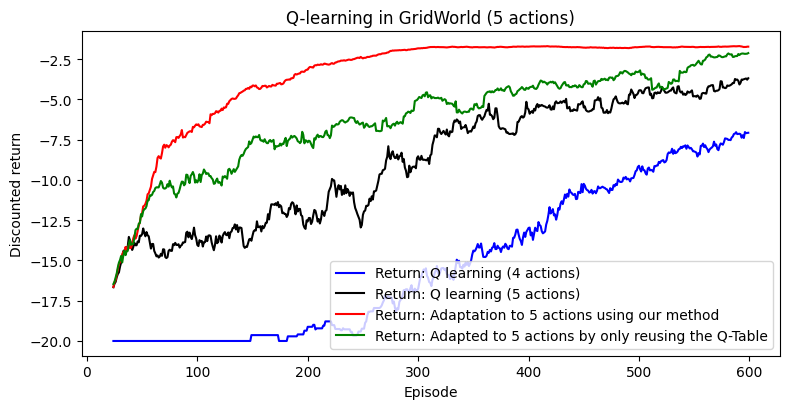

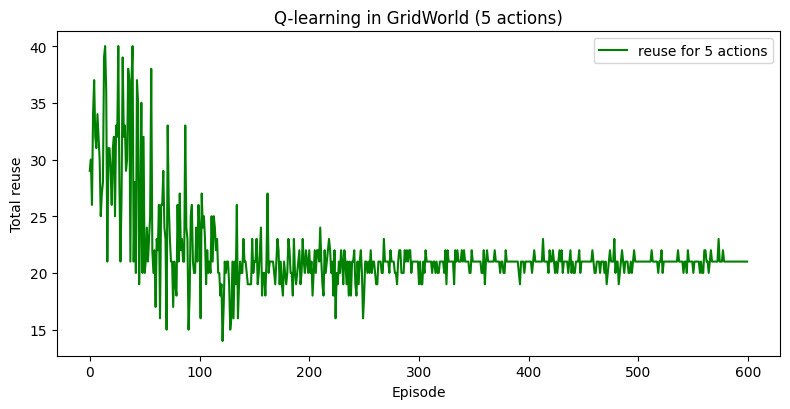

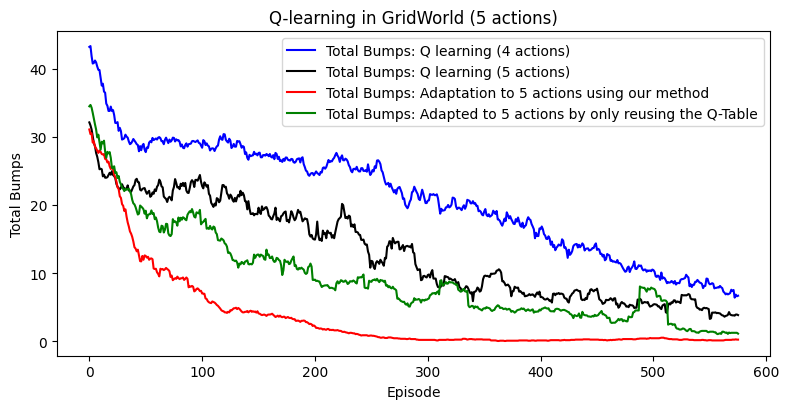

In [90]:
class OracleQLearningAgent(QLearningAgent):
    """Q-learning agent with oracle model for action adaptation"""
    
    def __init__(self, grid_world, n_actions, base_q_table=None, episodes=600, alpha=0.5, 
                 eps_start=1.0, eps_end=0.05, eps_decay_episodes=300, 
                 max_steps=200, seed=123, use_model = True):
        super().__init__(grid_world, n_actions, episodes, alpha, eps_start, eps_end, 
                        eps_decay_episodes, max_steps, seed)
        self.reuse_count = np.zeros(self.episodes, dtype = float)
        self.use_model = use_model
        # Initialize with base Q-table if provided
        if base_q_table is not None:
            self.Q[:, :base_q_table.shape[1]] = base_q_table
            # Optimistic initialization for new actions
            if use_model == True:
                V_old = np.max(base_q_table, axis=1) 
                for new_action in range(base_q_table.shape[1], n_actions):
                    self.Q[:, new_action] = V_old
    
    def train_with_oracle(self, actions_dict, epsilon_greedy_func, bump_reward, oracle_func, base_q_table):
        """Train with oracle model guidance"""
        eps = self.eps_start
        start_time = time.time()
        for ep in range(self.episodes):
            s = self.grid_world.start
            si = self.grid_world.to_index(s)
            done = False
            G = 0.0
            bumpcount = 0
            disc = 1.0
            steps = 0
            reuse = 0
            for t in range(self.max_steps):
                a = epsilon_greedy_func(self.Q[si], eps, self.rng)
                # Oracle guidance for new action (action 4)
                if self.use_model is True:
                  if a == 4:
                    snext_model = oracle_func(si)
                    snext_model_i = self.grid_world.to_index(snext_model)
                    # Only accept if it leads to better state value
                    if np.max(self.Q[snext_model_i]) < np.max(self.Q[si]):
                        # Fall back to original action set
                        a = epsilon_greedy_func(base_q_table[si], eps, self.rng)
                    else: 
                        reuse += 1
                s_next, r, done = self.grid_world.step(s, a, actions_dict)
                s_next_i = self.grid_world.to_index(s_next)

                if si == s_next_i:
                    bumpcount += 1
                    r = bump_reward
                    

                target = r if done else r + self.grid_world.gamma * np.max(self.Q[s_next_i])
                self.Q[si, a] += self.alpha * (target - self.Q[si, a])

                G += r
                disc *= self.grid_world.gamma
                s, si = s_next, s_next_i
                steps += 1
                if done:
                    break
            self.reuse_count[ep] = reuse    
            self.returns[ep] = G
            self.bumps[ep] = bumpcount
            self.steps_arr[ep] = steps
            
            if ep < self.eps_decay_episodes:
                eps = max(self.eps_end, eps - self.eps_decay)
        
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time:.4f} seconds")
        print(f'Training with oracle ({self.n_actions} actions) complete!')

# Usage example for oracle-guided Q-learning:
oracle_agent = OracleQLearningAgent(grid_world, 5, base_q_table=Q4, seed=SEED)
oracle_agent.train_with_oracle(ACTIONS_5, epsilon_greedy, BUMP_REWARD, oracle_model, Q4)
# ignore model
ignore_model = OracleQLearningAgent(grid_world, 5, base_q_table=Q4, seed=SEED, use_model = False)
ignore_model.train_with_oracle(ACTIONS_5, epsilon_greedy, BUMP_REWARD, oracle_model, Q4)
ignore_model_result = ignore_model.get_results(moving_average)
ignore_model_returns5 = ignore_model_result['returns']
ignore_model_bumps5 = ignore_model_result['bumps']
ignore_model_ret_ma5 = ignore_model_result['returns_ma']
ignore_model_steps_m5 = ignore_model_result['steps_ma']

policy5 = oracle_agent.get_policy(N_ROWS, N_COLS)
Visualizer.render_policy(policy5, N_ROWS, N_COLS, WALLS, START, GOAL)
Visualizer.print_value_grid(oracle_agent.Q, N_ROWS, N_COLS)

oracle_results = oracle_agent.get_results(moving_average)
returns5 = oracle_results['returns']
bumps5 = oracle_results['bumps']
ret_ma5 = oracle_results['returns_ma']
steps_m5 = oracle_results['steps_ma']

# Plot comparison results
ma_w = 25
bumps4_avg = moving_average(bumps4, w=ma_w)
bumps5plain_avg = moving_average(bumps5plain, w=ma_w)
bumps5_avg = moving_average(bumps5, w=ma_w)
ignore_model_bumps5_avg = moving_average(ignore_model_bumps5, w=ma_w)

plt.figure(figsize=(8, 4.2))
plt.plot(np.arange(len(returns4))[-len(ret_ma4):], ret_ma4, 'b', label='Return: Q learning (4 actions)')
plt.plot(np.arange(len(returns5plain))[-len(ret_ma5plain):], ret_ma5plain, 'k', label='Return: Q learning (5 actions)')
plt.plot(np.arange(len(returns5))[-len(ret_ma5):], ret_ma5, 'r', label='Return: Adaptation to 5 actions using our method')
plt.plot(np.arange(len(ignore_model_returns5))[-len(ignore_model_ret_ma5):], ignore_model_ret_ma5, 'g', label='Return: Adapted to 5 actions by only reusing the Q-Table')
plt.xlabel('Episode')
plt.ylabel('Discounted return')
plt.title('Q-learning in GridWorld (5 actions)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize = (8, 4.2))
plt.plot(oracle_agent.reuse_count, 'g', label = 'reuse for 5 actions')
plt.xlabel('Episode')
plt.ylabel('Total reuse')
plt.title('Q-learning in GridWorld (5 actions)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4.2))
plt.plot(bumps4_avg, 'b', label='Total Bumps: Q learning (4 actions)')
plt.plot(bumps5plain_avg, 'k', label='Total Bumps: Q learning (5 actions)')
plt.plot(bumps5_avg, 'r', label='Total Bumps: Adaptation to 5 actions using our method')
plt.plot(ignore_model_bumps5_avg, 'g', label='Total Bumps: Adapted to 5 actions by only reusing the Q-Table')
plt.xlabel('Episode')
plt.ylabel('Total Bumps')
plt.title('Q-learning in GridWorld (5 actions)')
plt.legend()
plt.tight_layout()
plt.show()

**2 things to note here: Our method learns faster and better policies than the 4 action case (which is expected) and we encounter fewer unsafe actions both compared to regular Q learning with 5 actions, as well as compared to the original Q learning with 4 actions.**

- present in a table data
- save data to dataFrame
- shaded error bar matplotlib
- plan in future (continuous state space, function approximate, transformer model to predict the next state of new action: https://arxiv.org/abs/2106.01345)
- scaleability of the model, make sure it is still useful when we have more actions: Theory analyze about this 
- update caption and research paper
- Add more lines for  literature review
